In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from IPython.display import display, Image
import ipywidgets as widgets
from pathlib import Path
import json

import sys
sys.path.append('../')
import cam_calib.camera_calibration as cc
# make sure to reload the module if it was already imported
import importlib
importlib.reload(cc)

<module 'cam_calib.camera_calibration' from 'c:\\Users\\akoss\\work\\hunbug\\repos\\cam_cv\\src\\uncalibrated_stereo\\..\\cam_calib\\camera_calibration.py'>

In [2]:
DATA_ROOT = Path('../../data')
IMAGE_1_NAME = Path('left.jpg')
IMAGE_2_NAME = Path('right.jpg')
# IMAGE_1_NAME = Path('tsukuba_l.png')
# IMAGE_2_NAME = Path('tsukuba_r.png')
CALIBRATION_FILE = Path('calibration.json')

In [3]:
# load the images
img1 = cv2.imread(str(DATA_ROOT / IMAGE_1_NAME))
img2 = cv2.imread(str(DATA_ROOT / IMAGE_2_NAME))

# load the camera matrices
camera_calibration = cc.CameraCalibParams.from_dict(
    json.load(open(str(DATA_ROOT / CALIBRATION_FILE)))
)

print(img1.shape)
print(img2.shape)
print(camera_calibration)

(480, 640, 3)
(480, 640, 3)
CameraCalibParams(camera_matrix=array([[648.20884237,   0.        , 339.34026668],
       [  0.        , 650.0823098 , 221.39155526],
       [  0.        ,   0.        ,   1.        ]]), dist_coeffs=array([[-0.06708032,  0.60630779, -0.00963969,  0.01939669, -1.28547567]]), rvecs=array([[-0.69132821],
       [ 0.02774438],
       [-0.04504523]]), tvecs=array([[-4.62994596],
       [-0.57317836],
       [22.19459063]]))


In [4]:
K = camera_calibration.camera_matrix

In [5]:
# take two images and find the fundamental matrix between them
# use the fundamental matrix to find the epipolar lines in the second image
# use the epipolar lines to find the epipoles
# use the epipoles to find the essential matrix
# use the essential matrix to find the camera matrices
# use the camera matrices to find the 3D points

# find the keypoints and descriptors with SIFT
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None) # left image
kp2, des2 = sift.detectAndCompute(img2,None) # right image

# find the matches
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
# Apply ratio test
good = []
pts1 = []
pts2 = []

for m,n in matches:
    if m.distance < 0.25*n.distance:
        good.append([m])
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

# find the fundamental matrix
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

# find the epilines
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)

# find the epipoles
epipole1 = cv2.computeCorrespondEpilines(np.array([[0,0]]), 2,F)
epipole1 = epipole1.reshape(-1,3)
epipole2 = cv2.computeCorrespondEpilines(np.array([[0,0]]), 1,F)
epipole2 = epipole2.reshape(-1,3)



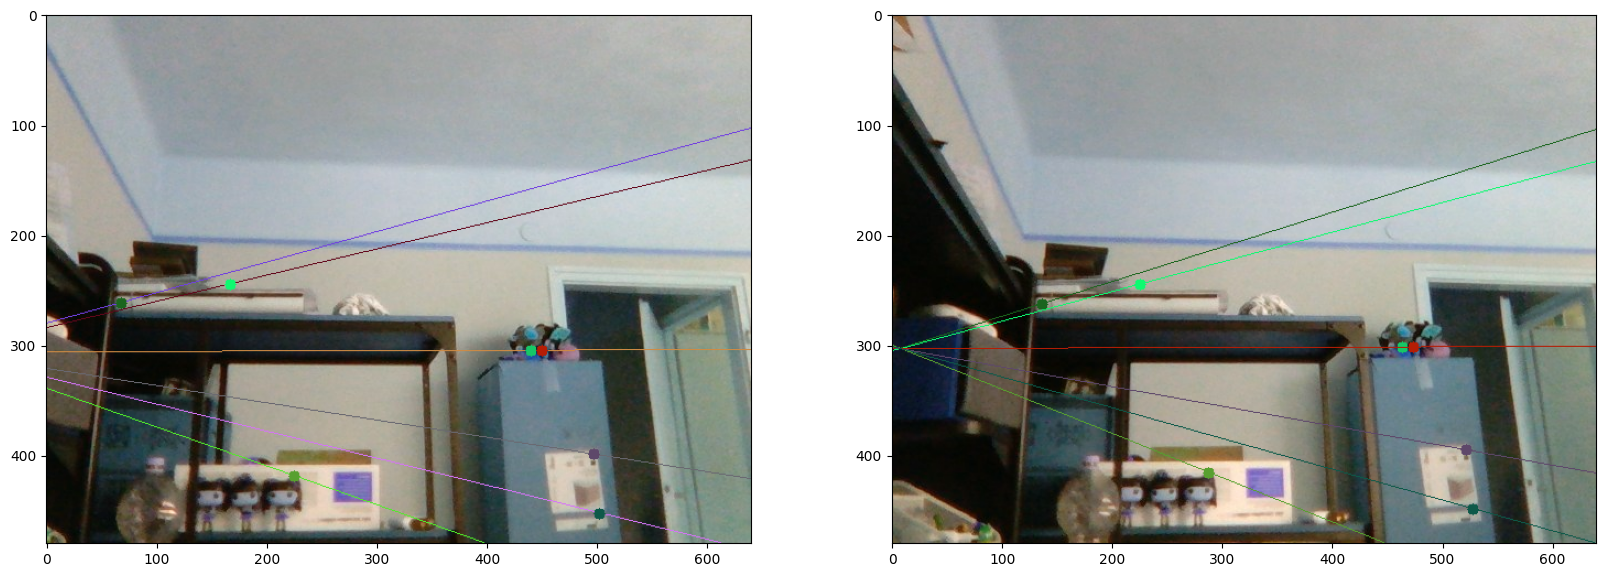

In [6]:
# Draw the epipolar lines on the images

def drawlines(img1,img2,lines, pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape[:2]
    img1_res = img1.copy()
    img2_res = img2.copy()
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1_res = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1_res = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2_res = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1_res,img2_res

img_left_to_right_1, img_left_to_right_2 = drawlines(img1,img2,lines1,pts1,pts2)
img_right_to_left_1, img_right_to_left_2 = drawlines(img2,img1,lines2,pts2,pts1)

fig, ax = plt.subplots(1,2, figsize=(20,10))
ax[0].imshow(img_left_to_right_1)
ax[1].imshow(img_right_to_left_1)
plt.show()

In [7]:
# find the essential matrix
E = K.T @ F @ K

# find the camera matrices
W = np.array([[0,-1,0],[1,0,0],[0,0,1]])
U, S, V = np.linalg.svd(E)
R1 = U @ W @ V
R2 = U @ W.T @ V
t1 = U[:,2]
t2 = -U[:,2]

# find the 3D points
P1 = K @ np.hstack((np.eye(3),np.zeros((3,1))))
P2 = K @ np.hstack((R1,t1.reshape(3,1)))
P3 = K @ np.hstack((R1,t2.reshape(3,1)))
P4 = K @ np.hstack((R2,t1.reshape(3,1)))
P5 = K @ np.hstack((R2,t2.reshape(3,1)))



In [8]:
# check if inputs are correct
print("P1: ", P1)
print("P2: ", P2)
print("P3: ", P3)
print("P4: ", P4)
print("P5: ", P5)

# check if inputs are correct
print("pts1: ", pts1)
print("pts2: ", pts2)

P1:  [[648.20884237   0.         339.34026668   0.        ]
 [  0.         650.0823098  221.39155526   0.        ]
 [  0.           0.           1.           0.        ]]
P2:  [[ 6.12195760e+02  2.81935827e+00  4.00668096e+02  6.20280616e+00]
 [ 2.66730164e+02  5.91783426e+02 -2.24206660e+02  2.68336094e+02]
 [ 8.62088643e-01 -1.92115239e-01 -4.68929533e-01  8.84306804e-01]]
P3:  [[ 6.12195760e+02  2.81935827e+00  4.00668096e+02 -6.20280616e+00]
 [ 2.66730164e+02  5.91783426e+02 -2.24206660e+02 -2.68336094e+02]
 [ 8.62088643e-01 -1.92115239e-01 -4.68929533e-01 -8.84306804e-01]]
P4:  [[-6.05350281e+02 -4.16599806e+00 -4.10926030e+02  6.20280616e+00]
 [ 2.94082194e+01 -6.50039649e+02 -2.19556010e+02  2.68336094e+02]
 [ 1.13841147e-01  1.30725307e-04 -9.93498956e-01  8.84306804e-01]]
P5:  [[-6.05350281e+02 -4.16599806e+00 -4.10926030e+02 -6.20280616e+00]
 [ 2.94082194e+01 -6.50039649e+02 -2.19556010e+02 -2.68336094e+02]
 [ 1.13841147e-01  1.30725307e-04 -9.93498956e-01 -8.84306804e-01]]
p

In [9]:
points1 = cv2.triangulatePoints(P1,P2,pts1.T,pts2.T)

In [10]:
# triangulate the points
points1 = cv2.triangulatePoints(P1,P2,pts1.T,pts2.T)
points2 = cv2.triangulatePoints(P1,P3,pts1.T,pts2.T)
points3 = cv2.triangulatePoints(P1,P4,pts1.T,pts2.T)
points4 = cv2.triangulatePoints(P1,P5,pts1.T,pts2.T)

# convert to inhomogeneous coordinates
points1 = points1/points1[3,:]
points2 = points2/points2[3,:]
points3 = points3/points3[3,:]
points4 = points4/points4[3,:]

In [11]:

# plot the points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points1[0,:],points1[1,:],points1[2,:],c='r',marker='o')
ax.scatter(points2[0,:],points2[1,:],points2[2,:],c='b',marker='o')
ax.scatter(points3[0,:],points3[1,:],points3[2,:],c='g',marker='o')
ax.scatter(points4[0,:],points4[1,:],points4[2,:],c='y',marker='o')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

: 